# MRF rotor

This notebook explains the implementation of the Multiple Reference Approximation (MRF) for rotor modelling. The geometry consists of an isolated XV15 rotorcraft.


![XV 15 rotor](figures/poster_image.png)


## 1. Create a project from geometry:

* Load python libraries and Flow360 client.
* Get geometry files from example database. The geometry used in the path `XV15_CSM.geometry` is "XV15_Wing.csm", if you want to use your own geometry, replace this file path with your local path to your CAD file.
* Load the geometry according to the length unit used in the CAD software in which the model has been created 

In [1]:
import flow360 as fl
from flow360.examples.XV15_csm import XV15_CSM

import numpy as np
import matplotlib.pyplot as plt

XV15_CSM.get_files()
project = fl.Project.from_geometry(
    XV15_CSM.geometry, length_unit="inch", name="MRF tutorial from Python"
)
geometry = project.geometry

Output()

[12:30:50] INFO: Geometry successfully submitted:                                                                  
                   type        = Geometry                                                                          
                   name        = MRF tutorial from Python                                                          
                   id          = geo-6aa89928-0cc9-4f5c-91d9-3adbf052c317                                          
                   status      = uploaded                                                                          
                   project id  = prj-27ee099c-0348-44d6-a444-0e644487dfd9                                          
           

           INFO: Waiting for geometry to be processed.

Output()

## 2. Geometry Primitives Definition:

In order to apply the MRF approximation we have to define a cylinder corresponding to the rotating zone encapsulating the cylinder. We will also define a bigger cylinder which we will use to apply a volumetric refinement to the wake of the rotor.

The farfield is defined automatically and determines the limits of the simulation domain. This is also included in this code snippet with the class `fl.AutomatedFarfield()`.


In [2]:
with fl.SI_unit_system:

    farfield = fl.AutomatedFarfield()
    R = 3.81
    MRF_cylinder = fl.Cylinder(
        center=(0, 0, 0),
        outer_radius=190 * fl.u.inch,
        height=40 * fl.u.inch,
        axis=(0, 0, -1),
        name="RotatingCylinder",
    )

    Wake_Cylinder = fl.Cylinder(
        center=(0, 0, -200) * fl.u.inch,
        outer_radius=210 * fl.u.inch,
        height=500 * fl.u.inch,
        axis=(0, 0, -1),
        name="WakeCylinder",
    )

[12:31:23] INFO: using: SI unit system for unit inference.

## 3. Rotating Zone Definition

We use the RotatingCylinder Object to define the mesh volume zone in which the MRF approximation will be applied. We have to define the mesh properties at the interface between the volume zones, which will in turn, determine the overall mesh quality of the volume zone.

For further mesh refinement, a uniform volumetric refinement using the MRF_cylinder could be applied to ensure a more uniform volume mesh in the rotating zone.

In [3]:
RotatingZone = fl.RotationVolume(
    name="RotatingZone",
    spacing_axial=1 * fl.u.inch,
    spacing_circumferential=2 * fl.u.inch,
    spacing_radial=2 * fl.u.inch,
    entities=MRF_cylinder,
    enclosed_entities=geometry["*"],
)

## 4. Case Parameters Definition:

### 4.1 Meshing:

Having defined the basic information about the rotating zone we can define the different parameters which drive the simulation, starting from the meshing. The required inputs are:

1. Meshing Defaults: in this section the basic parameters needed to create the surface and volume meshes are determined. In this case they have been chosen to ensure sufficient accuracy across the blades and ensure y+<1

2. Volume Zones: for multizone meshes, all volume zones have to be specified. In this case we have a farfield and the rotating zone

3. Refinements: a number of refinements can be included to increase the accuracy of the mesh. 


In [4]:
meshing = fl.MeshingParams(
    defaults=fl.MeshingDefaults(
        surface_max_edge_length=1 * fl.u.inch,
        boundary_layer_first_layer_thickness=1.5e-6 * fl.u.m,
        curvature_resolution_angle=8 * fl.u.deg,
        boundary_layer_growth_rate=1.2,
    ),
    volume_zones=[farfield, RotatingZone],
    refinements=[fl.UniformRefinement(entities=Wake_Cylinder, spacing=30 * fl.u.mm)],
)

### 4.2 Final MRF Definition:

The MRF zone is established by defining a rotating region in the solver parameters. Using fl.Rotation() inside a fl.Steady configuration allows the solver to apply the MRF approximation.

In [5]:
omega = 589 * fl.u.rpm

MRF = fl.Rotation(name="MRF", volumes=MRF_cylinder, spec=fl.AngularVelocity(omega))

time_stepping = fl.Steady(
    max_steps=3500, CFL=fl.AdaptiveCFL(convergence_limiting_factor=0.75)
)

### 4.3 Dynamic parameters:

Having defined the time-stepping scheme and the MRF rotating zone. We have to specify the turbulence model, and reference geometry. All the parameters are then groped under the following sections. The physical configuration is intended to demonstrate the numerical implementation of a forward-flight case, rather than to represent a realistic operating condition for the rotor.

In [6]:
with fl.SI_unit_system:

    params = fl.SimulationParams(
        operating_condition=fl.AerospaceCondition.from_mach(
            mach=0.12,
            alpha=-90 * fl.u.deg,
        ),
        reference_geometry=fl.ReferenceGeometry(
            moment_center=(0, 0, 0), moment_length=(R, R, R), area=np.pi * R**2
        ),
        time_stepping=time_stepping,
        meshing=meshing,
        models=[
            fl.Fluid(
                navier_stokes_solver=fl.NavierStokesSolver(
                    low_mach_preconditioner=True, absolute_tolerance=1e-10
                ),
                turbulence_model_solver=fl.SpalartAllmaras(),
            ),
            fl.Wall(surfaces=geometry["*"]),
            fl.Freestream(surfaces=farfield.farfield),
            MRF,
        ],
        outputs=[
            fl.SurfaceOutput(
                surfaces=geometry["*"],
                output_fields=[
                    "primitiveVars",
                    "Cp",
                    "Cf",
                    "CfVec",
                ],
            ),
            fl.VolumeOutput(
                output_fields=[
                    "Mach",
                    "primitiveVars",
                    "qcriterion",
                    "Cp",
                ]
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

## 5. Running the case
Here we run the case using the beta mesher.

In [7]:
case = project.run_case(
    params=params, name="MRF tutorial from Python", use_beta_mesher=True
)

           INFO: using: SI unit system for unit inference.

[12:31:24] INFO: Selecting beta/in-house mesher for possible meshing tasks.

[12:31:26] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = MRF tutorial from Python                                                          
                   id          = case-49fa6c8e-3387-48b6-8bff-e250066bd048                                         
                   status      = pending                                                                           
                   project id  = prj-27ee099c-0348-44d6-a444-0e644487dfd9                                          
           

## 6. Numerical and Force Convergence

Having ran the case we can plot the thrust and non-linear residuals. Note that for the thrust we will need to use dimensional quantities from the case.

Output()

Output()

[12:56:12] INFO: using: SI unit system for unit inference.

Output()

[12:56:13] INFO: Saved to /tmp/tmpk8k0ogbt/5c9bfe83-0982-480d-bada-1f4ff441cf9c.csv

Output()

[12:56:14] INFO: Saved to /tmp/tmpk8k0ogbt/a4e587a7-8893-41fa-9b3a-1b98f6d98cac.csv

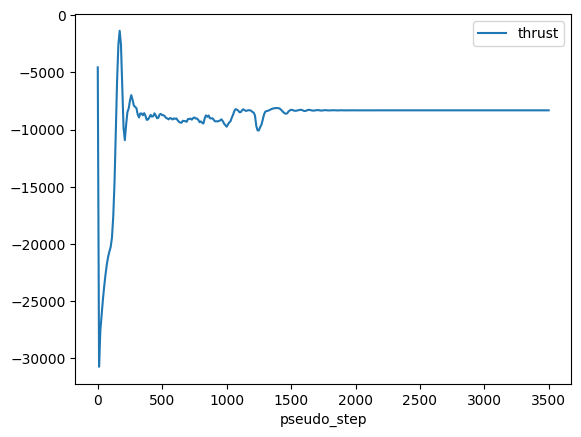

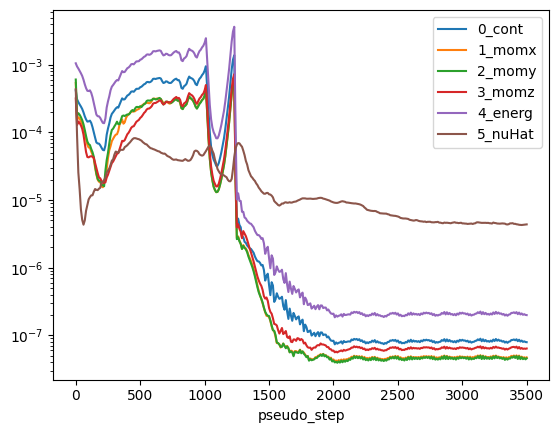

In [8]:
case.wait()

# Reference quantities
density = case.params.operating_condition.thermal_state.density
U_ref = (
    case.params.operating_condition.reference_velocity_magnitude
    or case.params.operating_condition.velocity_magnitude
)
A_ref = case.params.reference_geometry.area

# Get results
results = case.results

# Plot thrust
total_forces = case.results.total_forces.as_dataframe()
total_forces["thrust"] = total_forces["CFz"] * 0.5 * density * U_ref**2 * A_ref
total_forces.plot("pseudo_step", ["thrust"])

# Plot non-linear residuals
non_linear = case.results.nonlinear_residuals.as_dataframe()
non_linear.plot(
    "pseudo_step",
    ["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    logy=True,
)
plt.show()